# Stage 7 Homework — Outliers + Risk Assumptions

Notice, as the data is not currently operatable, I did the stage-9 feature engineering first to adjust the data that is easier to analyze.

In [30]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

## Load Data (provided or synthetic fallback)

In [31]:
data_path = Path('/Users/kevinjiang/bootcamp_Jianke_Jiang/project/data/processed/Trips_Tandon_Processed_20250823-185812.csv')

if data_path.exists():
    df = pd.read_csv(data_path, low_memory=False)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    print("else case")
print(df.head())

else case
                  hour  depart_frequency  arrive_frequency  tot_frequency  \
0  2025-05-14 20:00:00                 1                 1              2   
1  2025-05-14 21:00:00                 1                 2              3   
2  2025-05-14 22:00:00                 5                 5             10   
3  2025-05-14 23:00:00                 2                 1              3   
4  2025-05-15 00:00:00                 0                 1              1   

   depart_ratio  arrive_ratio  short_dist  mid_dist  long_dist  outlier_iqr  \
0      0.500000      0.500000    0.000000  0.001992   0.000000        False   
1      0.333333      0.666667    0.000000  0.001990   0.000995        False   
2      0.500000      0.500000    0.001984  0.004960   0.002976        False   
3      0.666667      0.333333    0.000000  0.002988   0.000000        False   
4      0.000000      1.000000    0.000000  0.000996   0.000000        False   

   outlier_z  win_freq  
0      False         1  
1 

## TODO: Implement Outlier Functions (required)

In [20]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [21]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [22]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0] #dailuy_return
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)


### Visual Checks (boxplot / histogram)

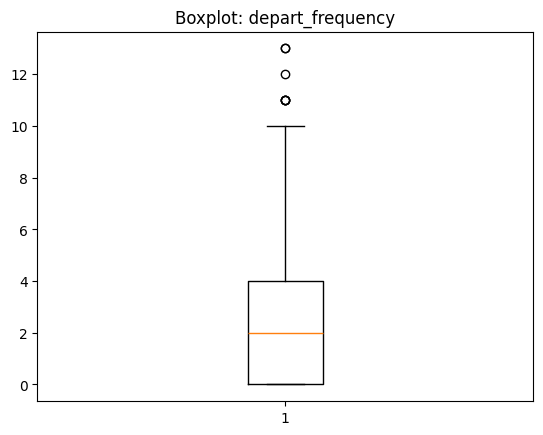

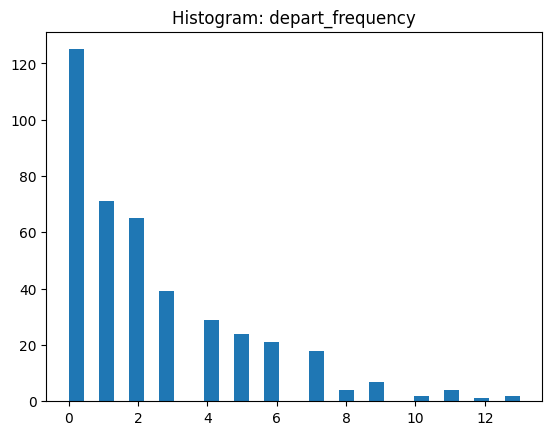

In [23]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [29]:
import numpy as np
import pandas as pd
import pathlib
import datetime as dt 

# Option A: Summary stats
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'}) # ~ is the negation operater here
# loc is used to filter the DataFrame based on the boolean mask
summ_w = None
# globals() returns a dictionary of all global variables and functions currently defined in the script or interactive session.
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
#** 是字典解包运算符，用于将一个字典的键值对展开并合并到外层字典中。
	#	如果 summ_w 不是 None，就构建一个字典 {'winsorized': summ_w}，然后解包进外层。
comp

df['win_freq'] = w


def ts():
    return dt.datetime.now().strftime('%Y%m%d-%H%M%S')
PROC = pathlib.Path("..") / "data/processed"
PROC.mkdir(parents=True, exist_ok=True)
output_file = PROC / f"Trips_Tandon_EDA_{ts()}.csv"
df.to_csv(output_file, index=False)


In [25]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

No 'x' column; skip regression or engineer features.


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*

I mainly use winsorize method replace data outside of the IQR with the max and min of the range. This is because my data is in form of time series, dropping any observation is not appropriate for future analysis, based on the box, my data is not normal and extremely skewed, therefore, using the z score would break the assumption of normal distribution. However, I am still assumping extreme data is outlier and not part of the data representing the reality. 
Based on the winsorized data, the mean decreased as my outliers are all to the max side of the data.
If the assumption is not correct, the model may face the risk of spurious regression in later stage.